# plotOutputs_FluxPIHM_2024.ipynb

## Original version by Andrew Virebicher, Spring 2022. Uses functions in pihm_utils
## Updated Fall 2024 by gcng

Plots the following outputs:
- Outlet discharge time series
- Time-averaged soil moisture
- Time-averaged evapotranspiration

### Recall about figures: 
If you want figures to "pop out," add: 
%matplotlib inline

To make it go back to appearing inside Jupyter lab, add:
%matplotlib qt 

In [19]:
import pandas as pd
test = pd.read_csv("input/Chimborazo_land_cover/Chimborazo_test.csv", delimiter = ' ')
test['LC'] = 22
test.to_csv('test.att', sep = '\t', index = False)

In [1]:
try:
    import pihm
except ImportError:
    print("Your computer does not have the PIHM-utils module, so this script will try to download it")
    
    # Fall 2024: added the below, based on PIHM_visualization.ipynb in MM-PIHM GitHub 
    # (Note that Spyder shows a warning in editor, but it may work. Otherwise, 
    #  run the below line in Python console first, or run 'pip install 
    #  pihm-utils' in terminal on Linux/Mac)
    !pip install pihm-utils
    
    import pihm
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import os

'c:\\Users\\huan1428\\Documents\\esci5331_hydro_modeling\\ESCI5331_Fall2024\\Flux-PIHM\\scripts'

### Customize to your computer

In [2]:
#===== Directory containing the Flux-PIHM 'input' and 'output' directories =====#
pihm_directory = "C:/Users/huan1428/Documents/esci5331_hydro_modeling/assignment_7"
#=========================================================#

#===== ONLY the name of the specific sub-subdirectories in 'input' and 'output', NOT the full path =====#
input_folder_name = "Chimborazo" # inside {pihm_directory}/input
output_folder_name = "Chimborazo"  # inside {pihm_directory}/output
#============================================================================#

## Enter files for what you want to plot

In [8]:
#===== What output files do we need? (Hint -- look at MM-PIHM manual) =====#
soil_moisture_output_name = "smc"         # What are the letters in the file extension for the total soil moisture ? (Hint -- it looks like ###0, ###1, ... ###10)
#canopy_evaporation_output_name = "?"    # These can all be found in the documentation
#soil_evaporation_output_name = "?"
#total_transpiration_output_name = "?"
##==========================================================================#

In [10]:
#===== Load the meshfile and river file =====#
num_elements, num_nodes, tri, x, y, zmin, zmax = pihm.read_mesh(pihm_directory, input_folder_name)
num_rivers, from_nodes, to_nodes, outlets = pihm.read_river(pihm_directory, input_folder_name)

lines = [[(x[node1], y[node1]), (x[node2], y[node2])] for (node1, node2) in zip(from_nodes, to_nodes)]
river_lines = LineCollection(lines, linewidths=2, colors="black")
river_lines_2 = LineCollection(lines, linewidths=2, colors="black")
#============================================#

#===== Load the output data =====#
print(f"Reading river discharge file...")
simulation_time, river_discharge, _, discharge_units = pihm.read_output(pihm_directory, input_folder_name, output_folder_name, "river.flx1")   # River discharge
outlet_discharge: np.ndarray = river_discharge[:,-1]

#print(f"Reading canopy evaporation file...")
#_, canopy_evaporation, _, canopy_evaporation_units = pihm.read_output(pihm_directory, input_folder_name, output_folder_name, canopy_evaporation_output_name)
#print(f"Reading soil evaporation file...")
#_, soil_evaporation, _, soil_evaporation_units = pihm.read_output(pihm_directory, input_folder_name, output_folder_name, soil_evaporation_output_name)
#print(f"Reading total transpiration file...")
#_, total_transpiration, _, total_transpiration_units = pihm.read_output(pihm_directory, input_folder_name, output_folder_name, total_transpiration_output_name)
#
# There are 10 soil moisture layers -- want the average over depth
print(f"Reading soil moisture files...")
soil_moisture_layers = []
for i in range(0,11,1):
    _, layer, _, _ = pihm.read_output(pihm_directory, input_folder_name, output_folder_name, f"smc{i}")
    if layer.mean() >= 0.0:
        soil_moisture_layers.append(layer)

## Take the time-average of each of the outputs
#print(f"Processing canopy evaporation data...")
#canopy_evaporation_avg = np.mean(canopy_evaporation, axis = 0)
#print(f"Processing soil evaporation data...")
#soil_evaporation_avg = np.mean(soil_evaporation, axis = 0)
#print(f"Processing total transpiration data...")
#total_transpiration_avg = np.mean(total_transpiration, axis = 0)
#
#total_evapotranspiration_avg = canopy_evaporation_avg + soil_evaporation_avg + total_transpiration_avg
#
soil_moisture_avg = np.zeros(num_elements)
print(f"Processing soil moisture data...")
for layer in soil_moisture_layers:
    soil_moisture_avg += (1.0/11.0) * np.mean(layer, axis = 0)
#================================#


Reading river discharge file...
Reading soil moisture files...
Processing soil moisture data...


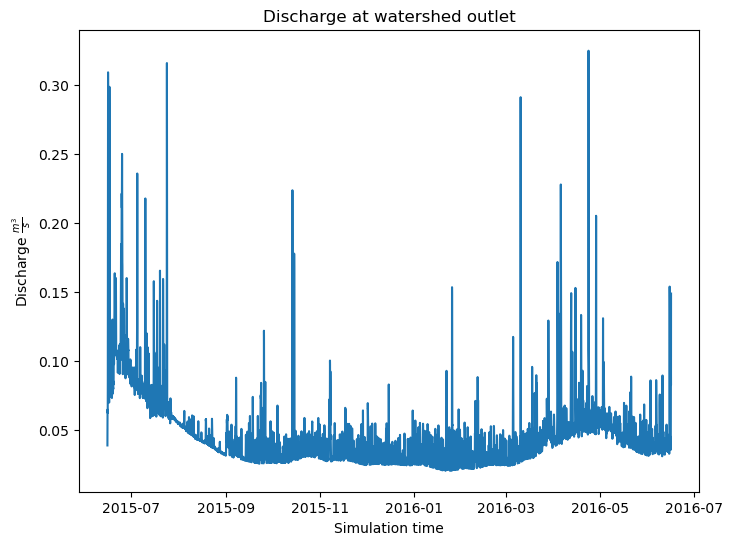

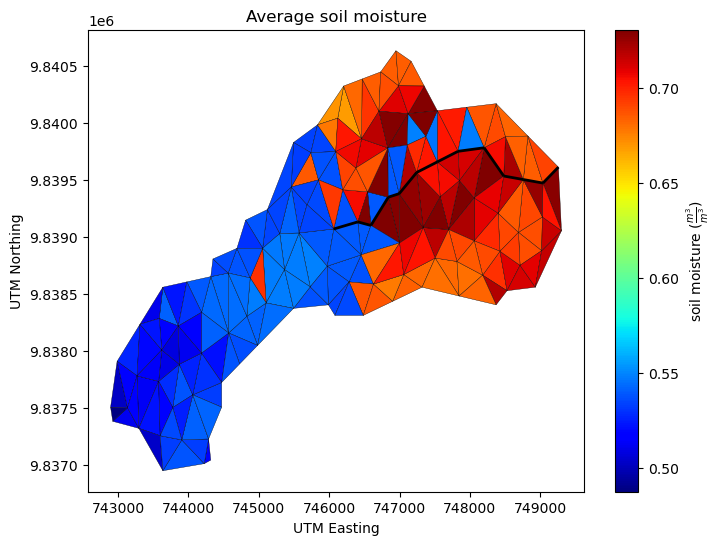

<Figure size 640x480 with 0 Axes>

In [ ]:
#===== Plot outputs =====#
dis = plt.figure(figsize = (8,6))
plt.plot(simulation_time, outlet_discharge)
plt.xlabel("Simulation time")
plt.ylabel(r"Discharge $\frac{m^3}{s}$")
plt.title("Discharge at watershed outlet")
dis.savefig('discharge.png', bbox_inches = 'tight')

#plt.figure(figsize=(8,6))
#plt.tripcolor(x,y,tri,facecolors = total_evapotranspiration_avg, cmap = "jet", shading = "flat", edgecolors = "k")
#plt.xlabel("UTM Easting")
#plt.ylabel("UTM Northing")
#plt.title(r"Total Evapotranspiration Rate $\frac{m}{s}$")
#plt.gca().add_collection(river_lines)
#plt.colorbar(label=r"ET Rate ($\frac{m}{s}$)")
#


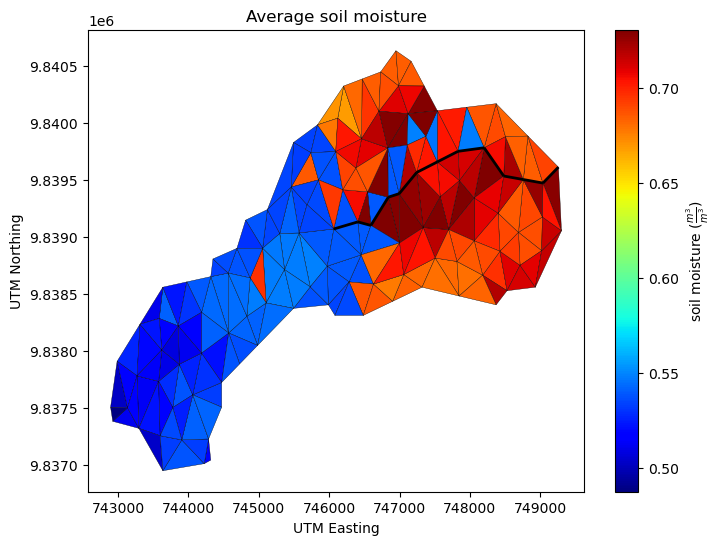

In [11]:

soil = plt.figure(figsize = (8,6))
plt.tripcolor(x,y,tri,facecolors = soil_moisture_avg, cmap = "jet", edgecolors = "k")
plt.xlabel("UTM Easting")
plt.ylabel("UTM Northing")
plt.title(r"Average soil moisture")
plt.colorbar(label=r"soil moisture ($\frac{m^3}{m^3})$")
plt.gca().add_collection(river_lines_2)
plt.show()
soil.savefig("soil_moisture.png", bbox_inches = 'tight')
#========================#